In [5]:
!pip install skshapes pyvista pyvista[jupyter]

  Using cached skshapes-0.3-py3-none-any.whl.metadata (6.8 kB)
  Using cached pyvista-0.46.5-py3-none-any.whl.metadata (15 kB)
  Using cached torchdiffeq-0.2.5-py3-none-any.whl.metadata (440 bytes)
  Using cached geomloss-0.2.6-py3-none-any.whl
  Using cached vedo-2025.5.4-py3-none-any.whl.metadata (14 kB)
  Using cached jupyter_server_proxy-4.4.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached trame_server-3.10.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached trame-3.12.0-py3-none-any.whl.metadata (8.2 kB)
Using cached skshapes-0.3-py3-none-any.whl (117 kB)
Using cached pyvista-0.46.5-py3-none-any.whl (2.4 MB)
Using cached trame-3.12.0-py3-none-any.whl (28 kB)
Using cached trame_server-3.10.0-py3-none-any.whl (44 kB)
Using cached jupyter_server_proxy-4.4.0-py3-none-any.whl (37 kB)
Using cached torchdiffeq-0.2.5-py3-none-any.whl (32 kB)
Using cached vedo-2025.5.4-py3-none-any.whl (2.8 MB)


## Imports

In [6]:
import os
import sys

# 1. On désactive la vérification de type AVANT d'importer quoi que ce soit
os.environ["JAXTYPING_DISABLE"] = "1"

# 2. On s'assure que skshapes n'est pas déjà dans le cache de Python
if "skshapes" in sys.modules:
    del sys.modules["skshapes"]

import torch
import skshapes as sks
import pyvista as pv
import numpy as np
import torch
import pyvista as pv
from IPython.display import Image

print("✅ Configuration prête : Jaxtyping est désactivé.")

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
✅ Configuration prête : Jaxtyping est désactivé.


## Utils

In [7]:
# --- 2. 3D PHYSICS FUNCTION ---
def apply_3d_retraction(mesh, center, strength=0.5, sigma=4.0):
    """
    Apply a 3D retraction force towards a center point.
    Works on PyVista meshes.
    """
    points = np.array(mesh.points)
    vectors = points - center
    distances = np.linalg.norm(vectors, axis=1)
    
    # Avoid division by zero
    distances = np.where(distances == 0, 0.001, distances)
    unit_vectors = vectors / distances[:, None]
    
    # Gaussian-shaped displacement
    displacement = strength * distances * np.exp(-(distances**2) / (2 * sigma**2))
    
    # Apply deformation
    new_points = points - (unit_vectors * displacement[:, None])
    
    # Return a new mesh with updated points
    deformed_mesh = mesh.copy()
    deformed_mesh.points = new_points
    return deformed_mesh

# --- 3. SHAPE GENERATORS ---

def get_liver_3d():
    # Create a base sphere and scale it to look like a liver lobe
    liver = pv.Sphere(radius=5.0, phi_resolution=50, theta_resolution=50)
    liver = liver.scale([1.8, 1.0, 0.7], inplace=False)
    return liver

def get_vessel_3d(center_ablation):
    # Points de contrôle décalés pour contourner la zone d'ablation (rayon 2.2)
    # On s'assure que la distance au centre est toujours > 2.5
    path_points = np.array([
        [-3.0,  3.0,  0.5],  # En haut à gauche
        [ 0.0,  3.0,  0.0],  # Passe au dessus
        [ 3.0,  0.0, -1.0],  # Contourne par la droite
        [ 2.0, -3.0,  0.0],  # Redescend
        [-2.0, -4.0,  0.5]   # Sortie en bas
    ]) + center_ablation
    
    spline = pv.Spline(path_points, 50)
    return spline.tube(radius=0.25)

def validate_setup(liver, tumor, ablation, vessel):
    """
    Validation script to ensure anatomical constraints are met.
    """
    print("--- Geometry Validation Report ---")
    
    def check_inside(inner_mesh, outer_mesh):
        # Returns the percentage of points from inner_mesh contained in outer_mesh
        select = inner_mesh.select_enclosed_points(outer_mesh)
        return select['SelectedPoints'].view(bool).mean() * 100

    # 1. Vessel inside Liver
    v_in_l = check_inside(vessel, liver)
    print(f"Vessel inside Liver: {v_in_l:.1f}%")

    # 2. Vessel outside Ablation Zone
    v_in_a = check_inside(vessel, ablation)
    print(f"Vessel inside Ablation Zone: {v_in_a:.1f}% (Should be 0.0%)")

    # 3. Tumor inside Ablation Zone
    t_in_a = check_inside(tumor, ablation)
    print(f"Tumor inside Ablation Zone: {t_in_a:.1f}%")

    # 4. Ablation Zone inside Liver
    a_in_l = check_inside(ablation, liver)
    print(f"Ablation Zone inside Liver: {a_in_l:.1f}%")

    # Global status
    is_valid = (v_in_l > 95) and (v_in_a < 5) and (t_in_a > 99) and (a_in_l > 95)
    if is_valid:
        print("\n✅ SETUP VALID: All anatomical constraints are satisfied.")
    else:
        print("\n❌ SETUP INVALID: Please adjust positions or scales.")

## Simulation setup

--- Geometry Validation Report ---
Vessel inside Liver: 100.0%
Vessel inside Ablation Zone: 0.0% (Should be 0.0%)
Tumor inside Ablation Zone: 100.0%
Ablation Zone inside Liver: 100.0%

✅ SETUP VALID: All anatomical constraints are satisfied.
Affichage des vues successives...


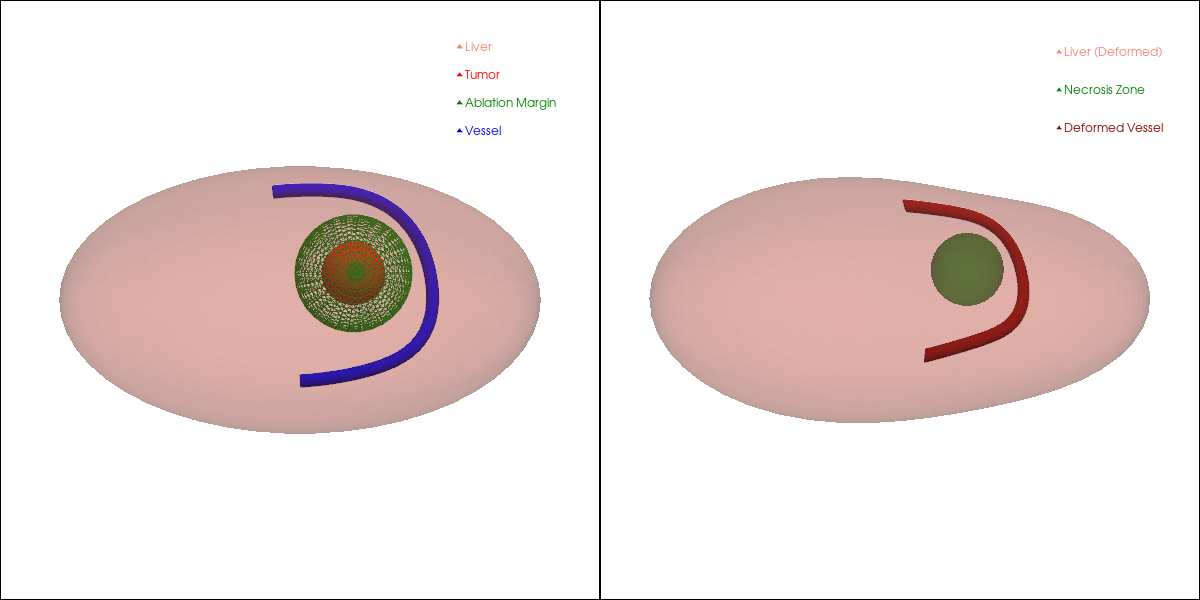

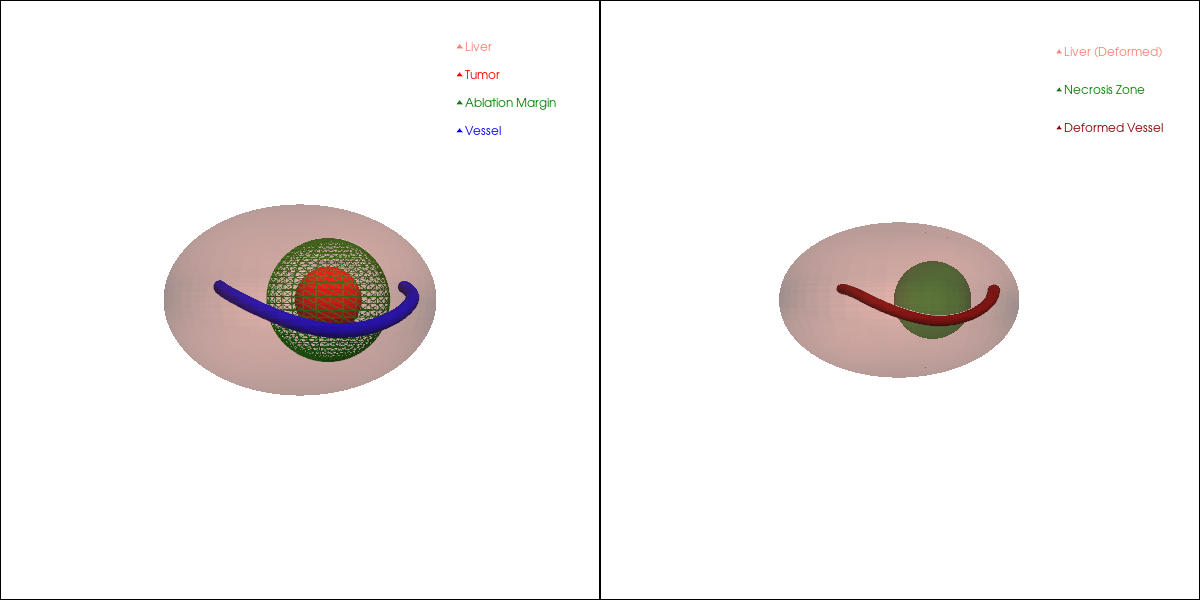

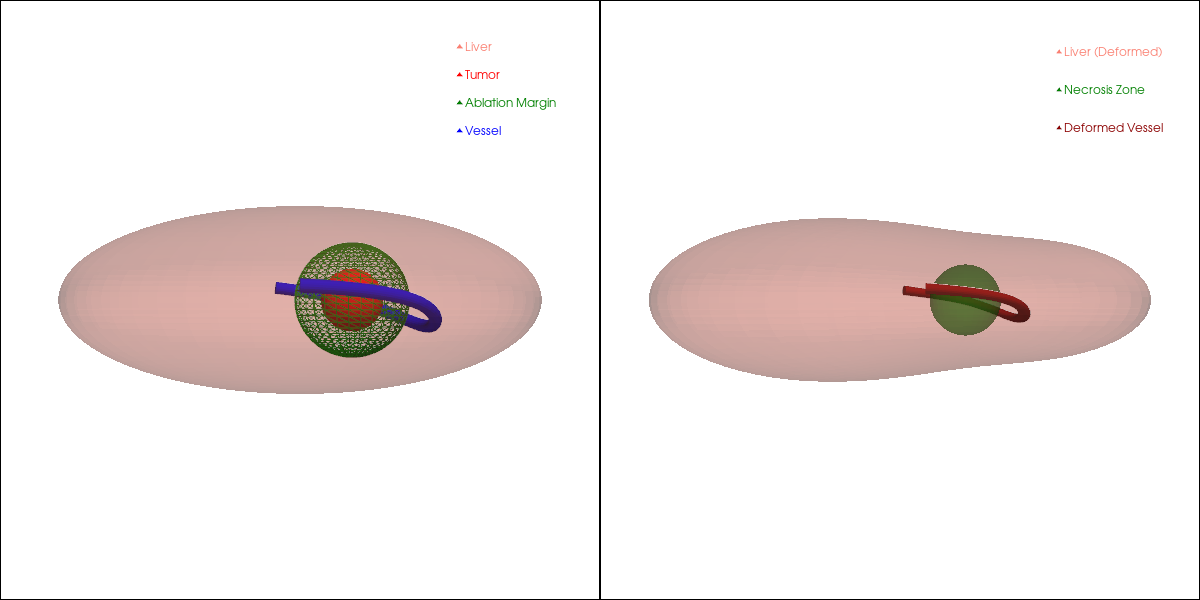

In [8]:
# --- 4. PARAMÈTRES ET GÉNÉRATION ---
center_point = np.array([2.0, 1.0, 0.0])
tumor_radius, ablation_radius = 1.2, 2.2

# PRE-OP
liver_pre = get_liver_3d()
tumor_pre = pv.Sphere(radius=tumor_radius, center=center_point)
ablation_pre = pv.Sphere(radius=ablation_radius, center=center_point)
vessel_pre = get_vessel_3d(center_point)

# POST-OP
liver_post = apply_3d_retraction(liver_pre, center_point)
ablation_post = apply_3d_retraction(ablation_pre, center_point)
vessel_post = apply_3d_retraction(vessel_pre, center_point)

# Run the validation
validate_setup(
    liver=liver_pre, 
    tumor=tumor_pre, 
    ablation=ablation_pre, 
    vessel=vessel_pre
)

# --- 5. FONCTION DE VISUALISATION PAR ANGLE ---

def render_comparison(view_name, view_func):
    filename = f"view_{view_name}.png"
    plotter = pv.Plotter(shape=(1, 2), off_screen=True, window_size=[1200, 600])
    
    # --- SUBPLOT 0: PRE-OP ---
    plotter.subplot(0, 0)
    plotter.add_text(f"PRE-OP: {view_name}", font_size=12, color="white")
    plotter.add_mesh(liver_pre, color="salmon", opacity=0.3, label="Liver")
    plotter.add_mesh(tumor_pre, color="red", label="Tumor")
    plotter.add_mesh(ablation_pre, color="green", style="wireframe", label="Ablation Margin")
    plotter.add_mesh(vessel_pre, color="blue", label="Vessel")
    plotter.add_legend(face=None) # Legend sans fond pour plus de clarté
    view_func(plotter) # Applique l'angle de caméra (XY, YZ ou XZ)

    # --- SUBPLOT 1: POST-OP ---
    plotter.subplot(0, 1)
    plotter.add_text(f"POST-OP: {view_name}", font_size=12, color="white")
    plotter.add_mesh(liver_post, color="salmon", opacity=0.3, label="Liver (Deformed)")
    plotter.add_mesh(ablation_post, color="green", opacity=0.5, label="Necrosis Zone")
    plotter.add_mesh(vessel_post, color="darkred", label="Deformed Vessel")
    plotter.add_legend(face=None)
    view_func(plotter)

    # Sauvegarde et affichage
    plotter.screenshot(filename)
    plotter.close()
    display(Image(filename))

# --- 6. EXÉCUTION SUCCESSIVE ---

print("Affichage des vues successives...")

# Vue de Face
render_comparison("Front View (XY)", lambda p: p.view_xy())

# Vue de Profil
render_comparison("Side View (YZ)", lambda p: p.view_yz())

# Vue de Dessus
render_comparison("Top View (XZ)", lambda p: p.view_xz())

## Recalage

In [9]:
def wrap_as_skshapes(pv_mesh):
    """Simple wrapper to convert PyVista mesh to skshapes PolyData"""
    return sks.PolyData(pv_mesh)

# The vessel fusion stays similar but uses 3D addition
def merge_3d_meshes(list_of_meshes):
    """Merges multiple PyVista meshes into one"""
    combined = pv.PolyData()
    for m in list_of_meshes:
        combined += m
    return combined


In [10]:
# --- 2. STRUCTURE ASSEMBLY (3D) ---

# Structure 1 & 2: Registration (Liver + Vessel)
# Note: we use the meshes generated by the simulation cell
structure_1_pre_reg = wrap_as_skshapes(liver_pre + vessel_pre)
structure_2_post_reg = wrap_as_skshapes(liver_post + vessel_post)

# Structure 3 & 4: Validation (Liver + Vessel + Ablation)
# Used to verify if the ablation zone follows the deformation correctly
structure_3_pre_full = wrap_as_skshapes(liver_pre + vessel_pre + ablation_pre)
structure_4_post_full = wrap_as_skshapes(liver_post + vessel_post + ablation_post)

In [11]:
# --- 3. HIGH DEFINITION REGISTRATION (3D) ---

source = structure_1_pre_reg
target = structure_2_post_reg

# Define a 3D control grid
# N=15 gives 15x15x15 = 3,375 control points
source.control_points = source.bounding_grid(N=15, offset=0.1)

model = sks.ExtrinsicDeformation(
    n_steps=5,         # Fewer steps for speed in 3D
    kernel="gaussian",
    scale=2.0,         # Scale must be larger in 3D to cover the volume
    control_points=True
)

registration = sks.Registration(
    model=model,
    loss=sks.OptimalTransportLoss(),
    optimizer=sks.LBFGS(),
    n_iter=30,
    regularization_weight=0.01, # Higher reg for 3D stability
    verbose=True
)

print(f"Number of 3D control points: {source.control_points.n_points}")
morphed = registration.fit_transform(source=source, target=target)

Number of 3D control points: 3375
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2))*c with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,3,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (-2*((a-b)*(d|c)))*Exp(-Sum((a-b)**2)) with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,3,1), d=Var(3,3,0) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (2*((a-b)*(d|c)))*Exp(-Sum((a-b)**2)) with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,3,1), d=Var(3,3,0) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula Exp(-Sum((a-b)**2))*d with a=Var(0,3,0), b=Var(1,3,1), d=Var(3,3,0) ... OK
Initial loss : 4.88e-01
  = 4.88e-01 + 0.01 * 0.00e+00 (fidelity + regularization_weight * regularization)
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (-2*((a-b)*(f|d)))*Exp(-Sum((a-b)**2)) with a=Var(0,3,0), b=Var(1,3,1), d=Var(3,3,0

In [12]:
# 1. On prépare la structure de validation
structure_validation = structure_3_pre_full

# 2. CRUCIAL : On lui donne la même grille de points de contrôle 
# que celle utilisée par la source lors du registration.fit_transform
structure_validation.control_points = source.control_points

# 3. Maintenant, le morphing va comprendre qu'il doit déplacer 
# la grille (3375 pts) pour déformer l'objet (4244 pts)
validation_morphing = registration.model.morph(
    shape=structure_validation,
    parameter=registration.parameter_
)

full_morphed = validation_morphing.morphed_shape

In [13]:
# --- 4. APPLY DEFORMATION TO FULL STRUCTURE ---

# We take the pre-op full structure (with ablation)
# and apply the parameters found during registration
validation_morphing = registration.model.morph(
    shape=structure_3_pre_full,
    parameter=registration.parameter_
)

full_morphed = validation_morphing.morphed_shape

# Now you can compare full_morphed with structure_4_post_full
# to see if the theoretical retraction matches the registered one.

--- VALIDATION DU RECALAGE 3D ---


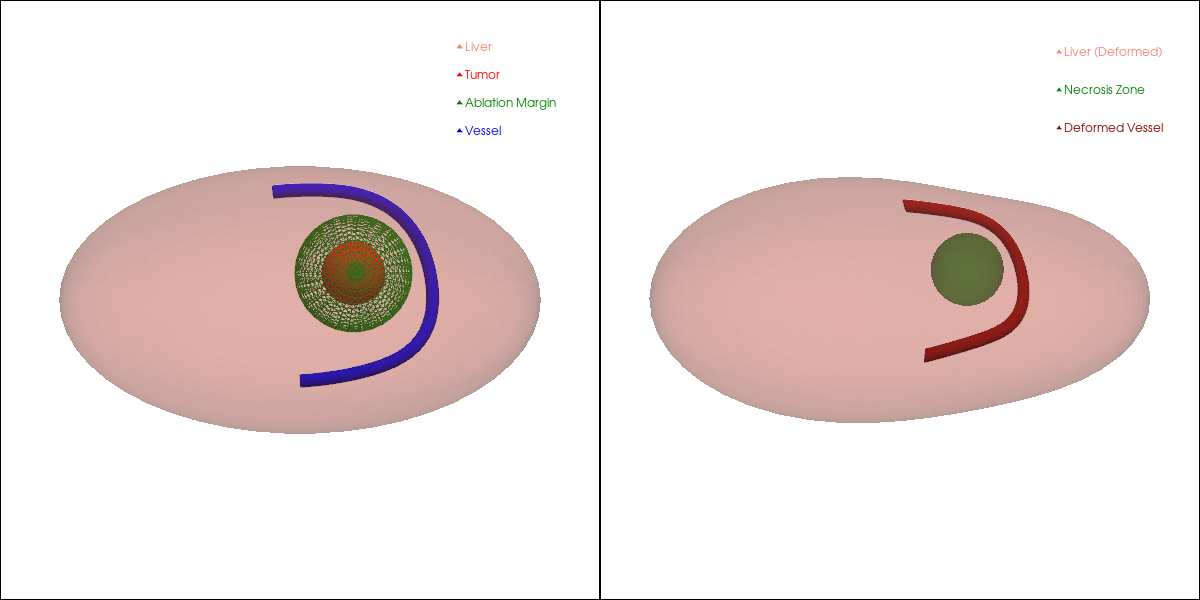

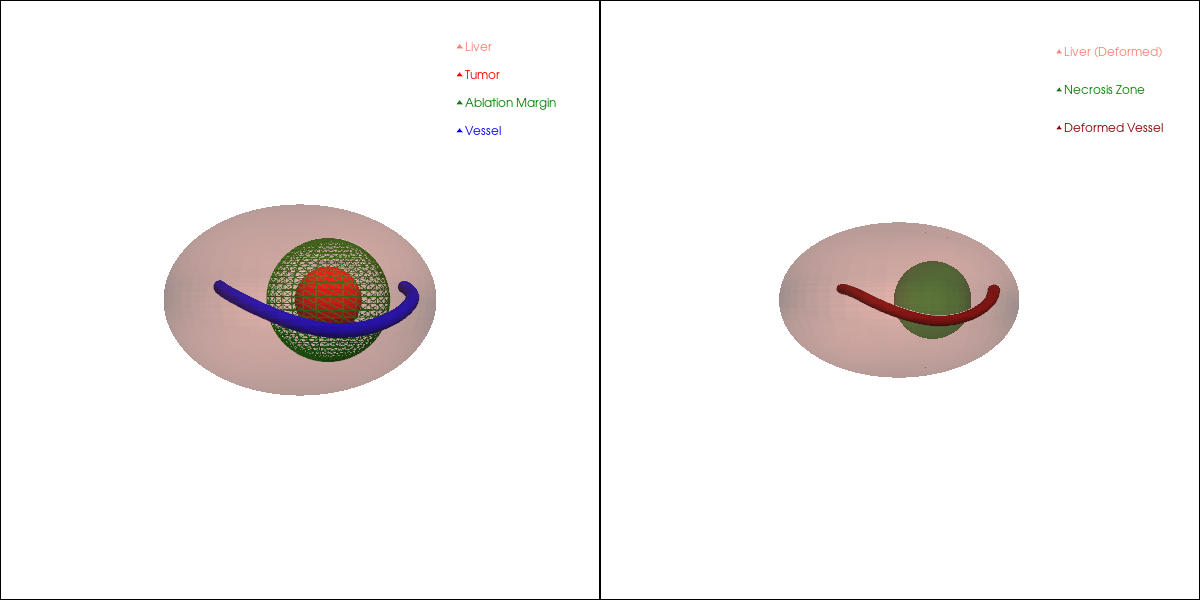

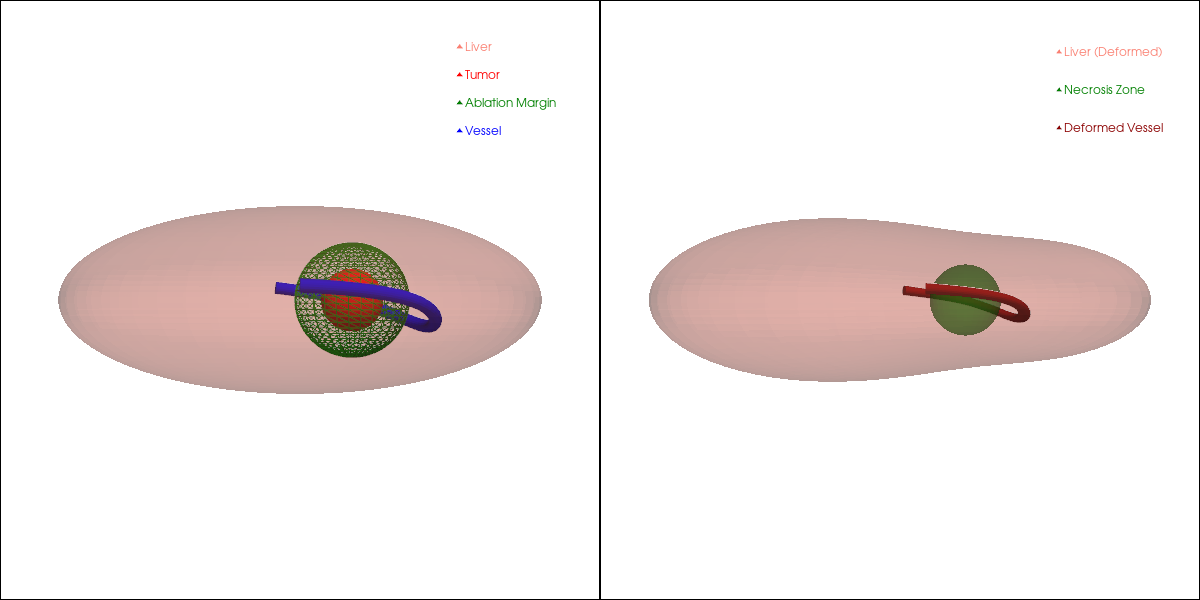

--- ANALYSE DE LA PRÉCISION DU RECALAGE (Prediction vs Reality) ---


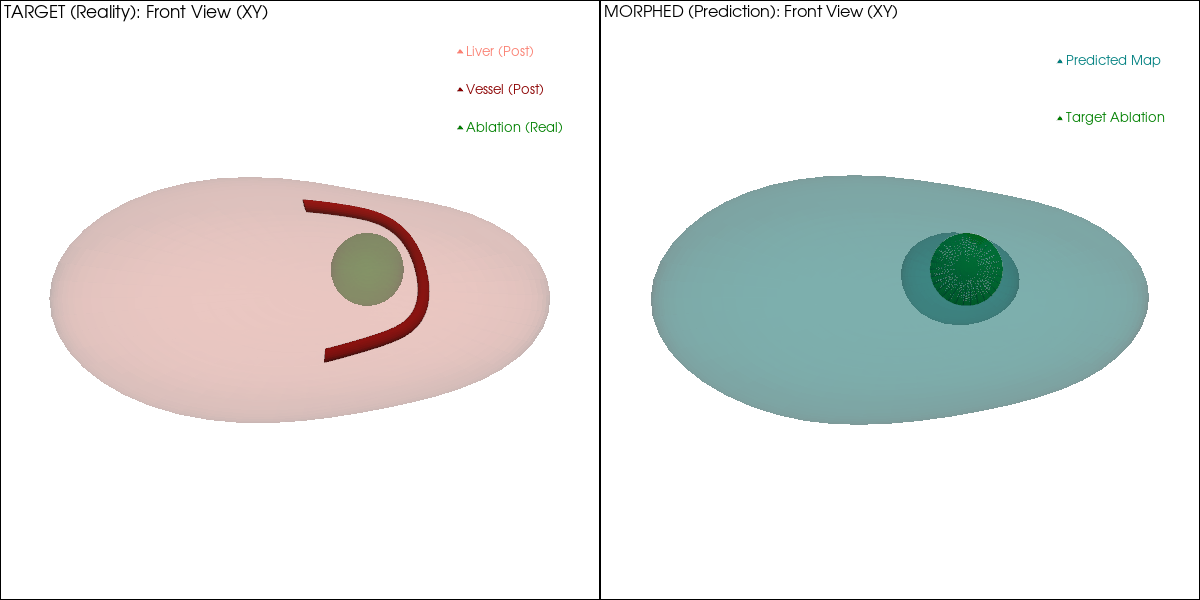

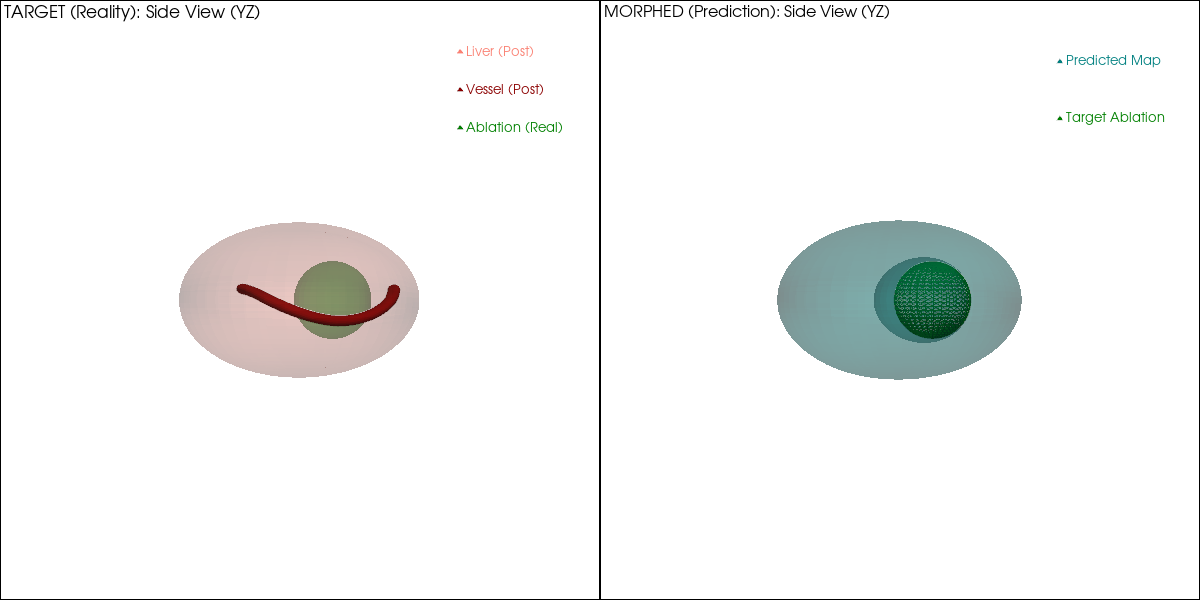

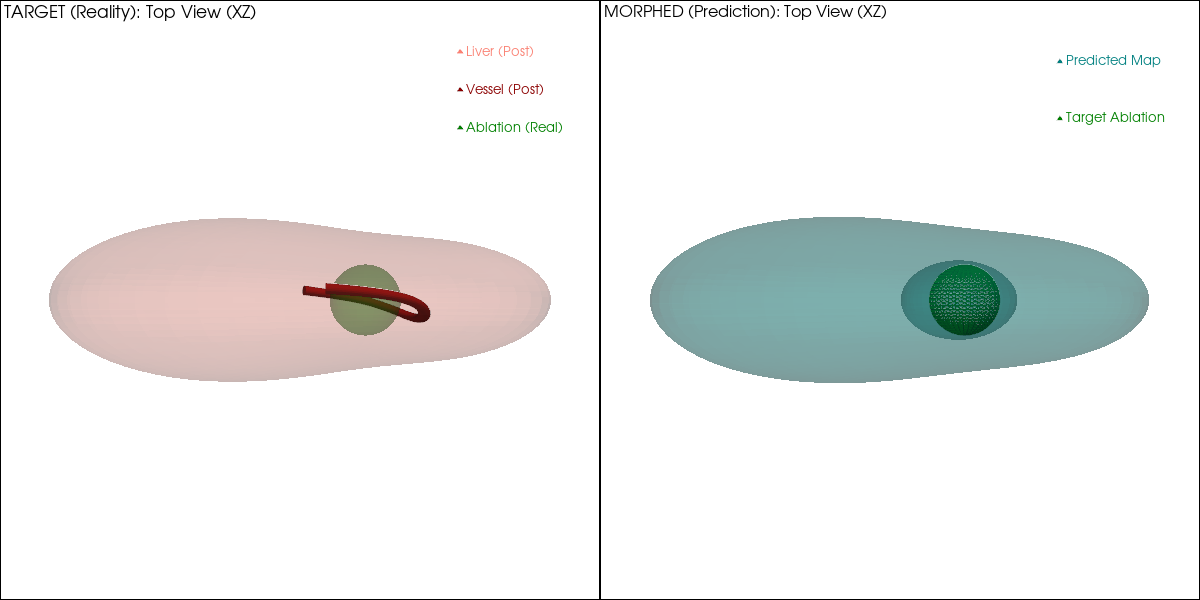

In [16]:
def render_validation_3d(view_name, view_func):
    filename = f"validation_{view_name}.png"
    # 2 colonnes : Target (Réalité simulée) vs Morphed (Prédiction du recalage)
    plotter = pv.Plotter(shape=(1, 2), off_screen=True, window_size=[1200, 600])
    
    # --- SUBPLOT 0: TARGET (La réalité du bloc opératoire) ---
    plotter.subplot(0, 0)
    plotter.add_text(f"TARGET (Reality): {view_name}", font_size=10)
    # On affiche la structure Post-Op simulée
    plotter.add_mesh(liver_post, color="salmon", opacity=0.2, label="Liver (Post)")
    plotter.add_mesh(vessel_post, color="darkred", label="Vessel (Post)")
    plotter.add_mesh(ablation_post, color="green", opacity=0.3, label="Ablation (Real)")
    plotter.add_legend()
    view_func(plotter)

    # --- SUBPLOT 1: MORPHED (La prédiction de l'algorithme) ---
    plotter.subplot(0, 1)
    plotter.add_text(f"MORPHED (Prediction): {view_name}", font_size=10)
    
    # On sépare les maillages du résultat 'full_morphed' pour la couleur
    # (full_morphed contient Foie + Vaisseau + Ablation fusionnés)
    plotter.add_mesh(full_morphed.to_pyvista(), color="teal", opacity=0.3, label="Predicted Map")
    
    # On peut aussi superposer la cible en fil de fer pour voir l'erreur
    plotter.add_mesh(ablation_post, color="green", style="wireframe", label="Target Ablation")
    plotter.add_legend()
    view_func(plotter)

    plotter.screenshot(filename)
    plotter.close()
    display(Image(filename))

# --- EXÉCUTION ---
print("--- VALIDATION DU RECALAGE 3D ---")
render_comparison("Face (XY)", lambda p: p.view_xy())
render_comparison("Profil (YZ)", lambda p: p.view_yz())
render_comparison("Dessus (XZ)", lambda p: p.view_xz())

# Utilise ce bloc pour une validation finale propre
print("--- ANALYSE DE LA PRÉCISION DU RECALAGE (Prediction vs Reality) ---")

# On définit l'affichage pour la validation
def view_logic(view_name, view_func):
    render_validation_3d(view_name, view_func)

# Appel successif
view_logic("Front View (XY)", lambda p: p.view_xy())
view_logic("Side View (YZ)", lambda p: p.view_yz())
view_logic("Top View (XZ)", lambda p: p.view_xz())